# Algorithmic Trading Model for Combo Moving Average Crossover Grid Search

## Task 1. Prepare Environment

In [1]:
import os
import sys
import numpy as np
import pandas as pd
import requests
import json
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from dotenv import load_dotenv

In [2]:
stock_symbol = 'JNJ'
initial_capital = 0

# Specify the moving average parameters for the trading strategy
fast_ema_min = 5
fast_ema_max = 30
slow_ema_min = 10
slow_ema_max = 60
fast_sma_min = 5
fast_sma_max = 30
slow_sma_min = 10
slow_sma_max = 60
ma_increment = 5
min_ma_gap = 5

# The number of extra days of data we need (usually equals to the larger of slow_ema or slow_sma)
extra_days_data = slow_sma_max

model_start_date = datetime(2019, 1, 1)
print("Starting date for the model:", model_start_date)
stock_start_date = model_start_date - timedelta(days=int(extra_days_data*1.5)) # Need more pricing data to calculate moving averages

model_end_date = datetime.now()
# model_end_date = datetime(2020, 6, 30)
print("Ending date for the model:", model_end_date)

Starting date for the model: 2019-01-01 00:00:00
Ending date for the model: 2020-07-29 23:20:29.807440


In [3]:
# Begin the timer for the script processing
startTimeScript = datetime.now()

# Set up the verbose flag to print detailed messages for debugging (setting True will activate!)
verbose_models = False
verbose_graphs = False
verbose_portfolios = False

# Set up the sendNotification flag to send progress emails (setting True will send emails!)
notifyStatus = False

# Set up the parent directory location for loading the dotenv files
useColab = False
if useColab:
    # Mount Google Drive locally for storing files
    from google.colab import drive
    drive.mount('/content/gdrive')
    gdrivePrefix = '/content/gdrive/My Drive/Colab_Downloads/'
    env_path = '/content/gdrive/My Drive/Colab Notebooks/'
    dotenv_path = env_path + "python_script.env"
    load_dotenv(dotenv_path=dotenv_path)

# Set up the dotenv file for retrieving environment variables
useLocalPC = False
if useLocalPC:
    env_path = "/Users/david/PycharmProjects/"
    dotenv_path = env_path + "python_script.env"
    load_dotenv(dotenv_path=dotenv_path)

# Configure the plotting style
plt.style.use('seaborn')

# Set Pandas options
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)
pd.set_option("display.width", 140)

## Task 2. Acquire and Pre-Process Data

In [4]:
# Check and see whether the API key is available
quandl_key = os.environ.get('QUANDL_API')
if quandl_key is None: sys.exit("API key for Quandl not available. Script Processing Aborted!!!")

In [5]:
start_date_string = stock_start_date.strftime('%Y-%m-%d')
end_date_string = model_end_date.strftime('%Y-%m-%d')

quandl_url = "https://www.quandl.com/api/v3/datatables/SHARADAR/SEP.json?date.gte=%s&date.lte=%s&ticker=%s&api_key=%s" % (start_date_string, end_date_string, stock_symbol, quandl_key)

In [6]:
response = requests.get(quandl_url)
quandl_dict = json.loads(response.text)
stock_quandl = pd.DataFrame(quandl_dict['datatable']['data'])
print(len(stock_quandl), 'data points retrieved from the API call.')

458 data points retrieved from the API call.


In [7]:
stock_quandl.columns = ['ticker', 'date', 'open', 'high', 'low', 'close', 'volume', 'dividend', 'closeunadj', 'lastupdated']
# stock_quandl.set_index('date', inplace=True)
stock_quandl.index = pd.to_datetime(stock_quandl.date)
stock_quandl = stock_quandl.sort_index(ascending=True)
stock_quandl.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 458 entries, 2018-10-03 to 2020-07-29
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   ticker       458 non-null    object 
 1   date         458 non-null    object 
 2   open         458 non-null    float64
 3   high         458 non-null    float64
 4   low          458 non-null    float64
 5   close        458 non-null    float64
 6   volume       458 non-null    float64
 7   dividend     458 non-null    float64
 8   closeunadj   458 non-null    float64
 9   lastupdated  458 non-null    object 
dtypes: float64(7), object(3)
memory usage: 39.4+ KB


In [8]:
stock_quandl.head()

,ticker,date,open,high,low,close,volume,dividend,closeunadj,lastupdated
date,,,,,,,,,,
2018-10-03,AAPL,2018-10-03,230.05,233.47,229.780,232.07,28654799.0,0.0,232.07,2020-05-01
2018-10-04,AAPL,2018-10-04,230.78,232.35,226.730,227.99,32042000.0,0.0,227.99,2020-05-01
2018-10-05,AAPL,2018-10-05,227.96,228.41,220.580,224.29,33580463.0,0.0,224.29,2020-05-01
2018-10-08,AAPL,2018-10-08,222.21,224.80,220.200,223.77,29663923.0,0.0,223.77,2020-05-01
2018-10-09,AAPL,2018-10-09,223.64,227.27,222.246,226.87,26891029.0,0.0,226.87,2020-05-01


In [9]:
stock_quandl.tail()

,ticker,date,open,high,low,close,volume,dividend,closeunadj,lastupdated
date,,,,,,,,,,
2020-07-23,AAPL,2020-07-23,387.993,388.310,368.039,371.38,49251108.0,0.0,371.38,2020-07-23
2020-07-24,AAPL,2020-07-24,363.950,371.880,356.580,370.46,46359716.0,0.0,370.46,2020-07-24
2020-07-27,AAPL,2020-07-27,374.840,379.620,373.920,379.24,29469969.0,0.0,379.24,2020-07-27
2020-07-28,AAPL,2020-07-28,377.470,378.199,372.990,373.01,25311293.0,0.0,373.01,2020-07-28
2020-07-29,AAPL,2020-07-29,375.000,380.920,374.850,380.16,21602404.0,0.0,380.16,2020-07-29


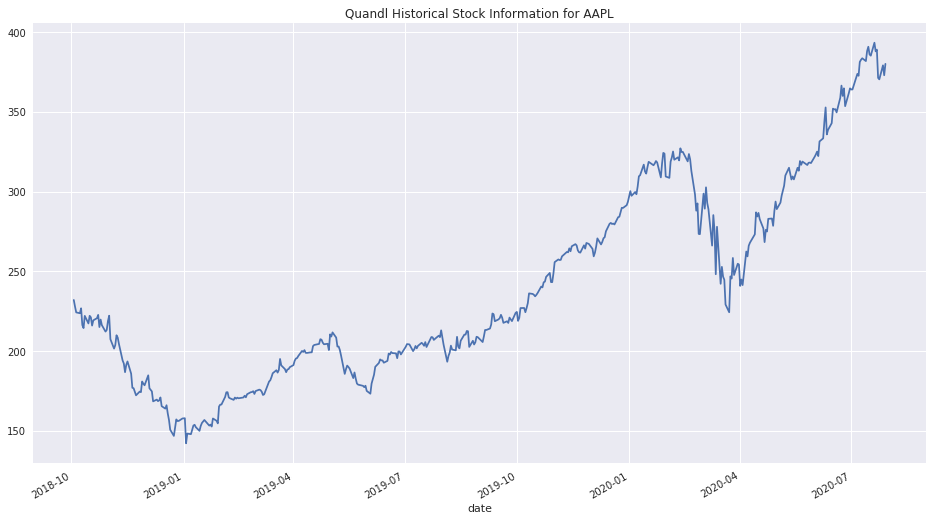

In [10]:
quandl_title = 'Quandl Historical Stock Information for ' + stock_symbol
stock_quandl['close'].plot(figsize=(16,9), title=quandl_title)
plt.show()

## Task 3. Develop Strategy and Train Model

### 3.a) Set up the Dataframe for the Trading Model

In [11]:
# Set up the standard column name for modeling
model_template = stock_quandl.loc[:, ['open','close']]
model_template.rename(columns={'open': 'open_price', 'close': 'close_price'}, inplace=True)
model_template.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 458 entries, 2018-10-03 to 2020-07-29
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   open_price   458 non-null    float64
 1   close_price  458 non-null    float64
dtypes: float64(2)
memory usage: 10.7 KB


### 3.b) Set up the Analysis Table with Indicators

In [12]:
# Define the functions that will generate the indicators and trading signals

def populate_indicators(passed_model):
    passed_model['fast_ema'] = passed_model['close_price'].ewm(span=fast_ma).mean()
    passed_model['slow_ema'] = passed_model['close_price'].ewm(span=slow_ma).mean()
    passed_model['fast_sma'] = passed_model['close_price'].rolling(fast_ma).mean()
    passed_model['slow_sma'] = passed_model['close_price'].rolling(slow_ma).mean()
    passed_model['ema_change'] = passed_model['fast_ema'] - passed_model['slow_ema']
    passed_model['sma_change'] = passed_model['fast_sma'] - passed_model['slow_sma']
    passed_model['fastema_slowsma_chg'] = passed_model['fast_ema'] - passed_model['slow_sma']
    passed_model['fastsma_slowema_chg'] = passed_model['fast_sma'] - passed_model['slow_ema']
    passed_model['trade_signal'] = np.zeros(len(passed_model))
    passed_model['signal_change'] = np.zeros(len(passed_model))
    passed_model['entry_exit'] = np.zeros(len(passed_model))

def populate_signals(model, change_curve):
    wait_for_entry = True
    for x in range(len(model)):
        if model[change_curve].iloc[x] > 0:
            model['trade_signal'].iloc[x] = 1  # trade_signal = 1 means we should enter into a long position
        else:
            model['trade_signal'].iloc[x] = 0  # trade_signal = 0 means we should exit the long position
        if x != 0:
            model['signal_change'].iloc[x] = model['trade_signal'].iloc[x] - model['trade_signal'].iloc[x-1]
            if wait_for_entry and (model['signal_change'].iloc[x-1] == 1):
                model['entry_exit'].iloc[x] = model['signal_change'].iloc[x-1]
                wait_for_entry = False
            elif (not wait_for_entry) and (model['signal_change'].iloc[x-1] != 0):
                model['entry_exit'].iloc[x] = model['signal_change'].iloc[x-1]


In [13]:
# Processing models using only the EMA curves
ema_model_collection = {}
serial_number = 1
for slow_ma in range(slow_ema_min, slow_ema_max+1, ma_increment):
    for fast_ma in range(fast_ema_min, fast_ema_max+1, ma_increment):
        if (slow_ma - fast_ma) < min_ma_gap: break
        if verbose_models: print('Processing model with fast_ema of', fast_ma, 'and slow_ema of', slow_ma)
        model_tag = 'EMA_' + str(serial_number).zfill(3) + '_FastEMA_' + str(fast_ma).zfill(3) + '_SlowEMA_' + str(slow_ma).zfill(3)
        serial_number = serial_number + 1
        trading_model = model_template.copy()
        populate_indicators(trading_model)
        trading_model = trading_model[model_start_date:model_end_date]
        populate_signals(trading_model, 'ema_change')
        ema_model_collection[model_tag] = trading_model.copy()
        if verbose_models: print('Model', model_tag, 'added to the trading model collection.')
print(len(ema_model_collection), 'EMA only models generated!')

# Processing models using only the SMA curves
print()
sma_model_collection = {}
serial_number = 1
for slow_ma in range(slow_sma_min, slow_sma_max+1, ma_increment):
    for fast_ma in range(fast_sma_min, fast_sma_max+1, ma_increment):
        if (slow_ma - fast_ma) < min_ma_gap: break
        if verbose_models: print('Processing model with fast_sma of', fast_ma, 'and slow_sma of', slow_ma)
        model_tag = 'SMA_' + str(serial_number).zfill(3) + '_FastSMA_' + str(fast_ma).zfill(3) + '_SlowSMA_' + str(slow_ma).zfill(3)
        serial_number = serial_number + 1
        trading_model = model_template.copy()
        populate_indicators(trading_model)
        trading_model = trading_model[model_start_date:model_end_date]
        populate_signals(trading_model, 'sma_change')
        sma_model_collection[model_tag] = trading_model.copy()
        if verbose_models: print('Model', model_tag, 'added to the trading model collection.')
print(len(sma_model_collection), 'SMA only models generated!')

# Processing models using fast EMA and slow SMA curves
print()
fast_ema_slow_sma_models = {}
serial_number = 1
for slow_ma in range(slow_sma_min, slow_sma_max+1, ma_increment):
    for fast_ma in range(fast_ema_min, fast_ema_max+1, ma_increment):
        if (slow_ma - fast_ma) < min_ma_gap: break
        if verbose_models: print('Processing model with fast_ema of', fast_ma, 'and slow_sma of', slow_ma)
        model_tag = 'Mixed_' + str(serial_number).zfill(3) + '_FastEMA_' + str(fast_ma).zfill(3) + '_SlowSMA_' + str(slow_ma).zfill(3)
        serial_number = serial_number + 1
        trading_model = model_template.copy()
        populate_indicators(trading_model)
        trading_model = trading_model[model_start_date:model_end_date]
        populate_signals(trading_model, 'fastema_slowsma_chg')
        fast_ema_slow_sma_models[model_tag] = trading_model.copy()
        if verbose_models: print('Model', model_tag, 'added to the trading model collection.')
print(len(fast_ema_slow_sma_models), 'Fast EMA/Slow SMA models generated!')

# Processing models using fast SMA and slow EMA curves
print()
fast_sma_slow_ema_models = {}
serial_number = 1
for slow_ma in range(slow_ema_min, slow_ema_max+1, ma_increment):
    for fast_ma in range(fast_sma_min, fast_sma_max+1, ma_increment):
        if (slow_ma - fast_ma) < min_ma_gap: break
        if verbose_models: print('Processing model with fast_sma of', fast_ma, 'and slow_ema of', slow_ma)
        model_tag = 'Mixed_' + str(serial_number).zfill(3) + '_FastSMA_' + str(fast_ma).zfill(3) + '_SlowEMA_' + str(slow_ma).zfill(3)
        serial_number = serial_number + 1
        trading_model = model_template.copy()
        populate_indicators(trading_model)
        trading_model = trading_model[model_start_date:model_end_date]
        populate_signals(trading_model, 'fastsma_slowema_chg')
        fast_sma_slow_ema_models[model_tag] = trading_model.copy()
        if verbose_models: print('Model', model_tag, 'added to the trading model collection.')
print(len(fast_sma_slow_ema_models), 'Fast SMA/Slow EMA models generated!')


51 EMA only models generated!

51 SMA only models generated!

51 Fast EMA/Slow SMA models generated!

51 Fast SMA/Slow EMA models generated!


In [14]:
# List the entry/exit points for each model
def list_model_entry_exit(model_collection):
    for model_name in model_collection:
        print('List the signal change and entry/exit points for', model_name)
        print(model_collection[model_name][(model_collection[model_name].signal_change != 0) | (model_collection[model_name].entry_exit != 0)])
        print()

In [15]:
if verbose_models: list_model_entry_exit(ema_model_collection)

In [16]:
if verbose_models: list_model_entry_exit(sma_model_collection)

In [17]:
if verbose_models: list_model_entry_exit(fast_ema_slow_sma_models)

In [18]:
if verbose_models: list_model_entry_exit(fast_sma_slow_ema_models)

In [19]:
def draw_model_graphs(model_name, trade_model, fast_ma_curve='fast_ema', slow_ma_curve='slow_ema'):
    graph_data = trade_model.copy()
    title_string = "Moving Average Crossover Model for " + model_name
    fig = plt.figure(figsize=(16,9))
    ylabel = stock_symbol + ' price in $'
    ax1 = fig.add_subplot(111, ylabel=ylabel, title=title_string)
    graph_data[fast_ma_curve].plot(ax=ax1, color='b', lw=2.)
    graph_data[slow_ma_curve].plot(ax=ax1, color='r', lw=2.)
    graph_data['close_price'].plot(ax=ax1, color='g')
    ax1.plot(graph_data.loc[graph_data.entry_exit == 1].index, graph_data.close_price[graph_data.entry_exit == 1], '^', markersize=7, color='k',label='buy')
    ax1.plot(graph_data.loc[graph_data.entry_exit == -1].index, graph_data.close_price[graph_data.entry_exit == -1], 'v', markersize=7, color='k',label='sell')
    plt.legend(loc='upper left')
    plt.show()

In [20]:
if verbose_graphs:
    for tag in ema_model_collection:
        draw_model_graphs(tag, ema_model_collection[tag], 'fast_ema', 'slow_ema')

In [21]:
if verbose_graphs:
    for tag in sma_model_collection:
        draw_model_graphs(tag, sma_model_collection[tag], 'fast_sma', 'slow_sma')

In [22]:
if verbose_graphs:
    for tag in fast_ema_slow_sma_models:
        draw_model_graphs(tag, fast_ema_slow_sma_models[tag], 'fast_ema', 'slow_sma')

In [23]:
if verbose_graphs:
    for tag in fast_sma_slow_ema_models:
        draw_model_graphs(tag, fast_sma_slow_ema_models[tag], 'fast_sma', 'slow_ema')

## Task 4. Back-test Model

In [24]:
def trading_portfolio_generation(initial_fund, trade_model):
    # Construct a portfolio to track the transactions and returns
    portfolio = pd.DataFrame(index=trade_model.index, columns=['trade_action', 'qty_onhand', 'cost_basis', 'sold_transaction', 'gain_loss', 'cash_onhand', 'position_value', 'total_position', 'accumu_return'])
    portfolio.iloc[0]['trade_action'] = 0
    portfolio.iloc[0]['qty_onhand'] = 0
    portfolio.iloc[0]['cost_basis'] = 0.00
    portfolio.iloc[0]['sold_transaction'] = 0.00
    portfolio.iloc[0]['gain_loss'] = 0.00
    portfolio.iloc[0]['cash_onhand'] = initial_capital
    portfolio.iloc[0]['position_value'] = 0.00
    portfolio.iloc[0]['total_position'] = initial_capital
    portfolio.iloc[0]['accumu_return'] = portfolio.iloc[0]['total_position'] - initial_fund
    recent_cost = 0

    # The conditional parameters below determine how the trading strategy will be carried out
    for i in range(1, len(portfolio)):
        if (trade_model.iloc[i]['entry_exit'] == 1) and (portfolio.iloc[i-1]['qty_onhand'] == 0):
            portfolio.iloc[i]['trade_action'] = 1
            portfolio.iloc[i]['qty_onhand'] = portfolio.iloc[i-1]['qty_onhand'] + portfolio.iloc[i]['trade_action']
            portfolio.iloc[i]['cost_basis'] = trade_model.iloc[i]['open_price'] * portfolio.iloc[i]['trade_action']
            portfolio.iloc[i]['sold_transaction'] = 0.00
            portfolio.iloc[i]['gain_loss'] = 0.00
            portfolio.iloc[i]['cash_onhand'] = portfolio.iloc[i-1]['cash_onhand'] - portfolio.iloc[i]['cost_basis']
            recent_cost = trade_model.iloc[i]['open_price'] * portfolio.iloc[i]['trade_action']
            if verbose_portfolios: print('BOUGHT QTY:', portfolio.iloc[i]['trade_action'], 'on', portfolio.index[i], 'at the price of', trade_model.iloc[i]['open_price'])
        elif (trade_model.iloc[i]['entry_exit'] == -1) and (portfolio.iloc[i-1]['qty_onhand'] > 0):
            portfolio.iloc[i]['trade_action'] = -1
            portfolio.iloc[i]['qty_onhand'] = portfolio.iloc[i-1]['qty_onhand'] + portfolio.iloc[i]['trade_action']
            portfolio.iloc[i]['cost_basis'] = 0.00
            portfolio.iloc[i]['sold_transaction'] = trade_model.iloc[i]['open_price'] * portfolio.iloc[i]['trade_action'] * -1
            portfolio.iloc[i]['gain_loss'] = (recent_cost + (trade_model.iloc[i]['open_price'] * portfolio.iloc[i]['trade_action'])) * -1
            portfolio.iloc[i]['cash_onhand'] = portfolio.iloc[i-1]['cash_onhand'] + portfolio.iloc[i]['sold_transaction']
            recent_cost = 0.00
            if verbose_portfolios: print('SOLD QTY:', portfolio.iloc[i]['trade_action'], 'on', portfolio.index[i], 'at the price of', trade_model.iloc[i]['open_price'])
        else:
            portfolio.iloc[i]['trade_action'] = 0
            portfolio.iloc[i]['qty_onhand'] = portfolio.iloc[i-1]['qty_onhand']
            portfolio.iloc[i]['cost_basis'] = portfolio.iloc[i-1]['cost_basis']
            portfolio.iloc[i]['sold_transaction'] = 0.00
            portfolio.iloc[i]['gain_loss'] = 0.00
            portfolio.iloc[i]['cash_onhand'] = portfolio.iloc[i-1]['cash_onhand']
        portfolio.iloc[i]['position_value'] = trade_model.iloc[i]['close_price'] * portfolio.iloc[i]['qty_onhand']
        portfolio.iloc[i]['total_position'] = portfolio.iloc[i]['cash_onhand'] + portfolio.iloc[i]['position_value']
        portfolio.iloc[i]['accumu_return'] = portfolio.iloc[i]['total_position'] - initial_fund

    return portfolio

In [25]:
def generate_portfolio_and_performance(model_collection):
    # Initialize a dictionary for tracking portfolios for all models
    portfolio_collection = {}
    # Initialize a dataframe for reporting model performance summary
    performance_summary = pd.DataFrame(columns=['model_name','return_value','return_percent'])

    for model_name in model_collection:
        if verbose_portfolios: print('Processing portfolio for model:', model_name)
        portfolio_collection[model_name] = trading_portfolio_generation(initial_capital, model_collection[model_name])
        trade_transactions = portfolio_collection[model_name][portfolio_collection[model_name].trade_action != 0]
        if verbose_portfolios: print(trade_transactions)
        if verbose_portfolios: print('Accumulated profit/loss for one share of stock with initial capital of $%.0f at the end of modeling period: $%.2f' % (initial_capital, portfolio_collection[model_name].accumu_return[-1]))
        if initial_capital != 0:
            return_percentage = portfolio_collection[model_name].accumu_return[-1] / initial_capital * 100
            if verbose_portfolios: print('Accumulated return percentage based on the initial capital investment: %.2f%%' % return_percentage)
        else:
            return_percentage = None
        if trade_transactions.iloc[-1]['trade_action'] == 1:
            if verbose_portfolios: print('The current status of the model is:', 'Holding a position since', trade_transactions.index.tolist()[-1], '\n')
        else:
            if verbose_portfolios: print('The current status of the model is:', 'Waiting to enter since', trade_transactions.index.tolist()[-1], '\n')
        performance_summary = performance_summary.append({'model_name': model_name, 'return_value': portfolio_collection[model_name].accumu_return[-1], 'return_percent': return_percentage}, ignore_index=True)
    performance_summary.sort_values(by=['return_value'], inplace=True, ascending=False)
    return portfolio_collection, performance_summary

In [26]:
ema_portfolio_collection, ema_performance_summary = generate_portfolio_and_performance(ema_model_collection)
print(len(ema_portfolio_collection), 'trading transaction portfolios generated.')
print(len(ema_performance_summary), 'profit/loss performance summaries generated.')

51 trading transaction portfolios generated.
51 profit/loss performance summaries generated.


In [27]:
sma_portfolio_collection, sma_performance_summary = generate_portfolio_and_performance(sma_model_collection)
print(len(sma_portfolio_collection), 'trading transaction portfolios generated.')
print(len(sma_performance_summary), 'profit/loss performance summaries generated.')

51 trading transaction portfolios generated.
51 profit/loss performance summaries generated.


In [28]:
fast_ema_slow_sma_portfolios, fast_ema_slow_sma_performance = generate_portfolio_and_performance(fast_ema_slow_sma_models)
print(len(fast_ema_slow_sma_portfolios), 'trading transaction portfolios generated.')
print(len(fast_ema_slow_sma_performance), 'profit/loss performance summaries generated.')

51 trading transaction portfolios generated.
51 profit/loss performance summaries generated.


In [29]:
fast_sma_slow_ema_portfolios, fast_sma_slow_ema_performance = generate_portfolio_and_performance(fast_sma_slow_ema_models)
print(len(fast_sma_slow_ema_portfolios), 'trading transaction portfolios generated.')
print(len(fast_sma_slow_ema_performance), 'profit/loss performance summaries generated.')

51 trading transaction portfolios generated.
51 profit/loss performance summaries generated.


In [30]:
# Display the top models from EMA-only performance summary
ema_performance_summary.head()

,model_name,return_value,return_percent
1,EMA_002_FastEMA_005_SlowEMA_015,238.779,None
3,EMA_004_FastEMA_005_SlowEMA_020,225.140,None
6,EMA_007_FastEMA_005_SlowEMA_025,225.050,None
2,EMA_003_FastEMA_010_SlowEMA_015,224.580,None
0,EMA_001_FastEMA_005_SlowEMA_010,220.960,None


In [31]:
# Display the top models from SMA-only performance summary
sma_performance_summary.head()

,model_name,return_value,return_percent
1,SMA_002_FastSMA_005_SlowSMA_015,266.519,None
0,SMA_001_FastSMA_005_SlowSMA_010,241.654,None
6,SMA_007_FastSMA_005_SlowSMA_025,240.670,None
4,SMA_005_FastSMA_010_SlowSMA_020,228.520,None
3,SMA_004_FastSMA_005_SlowSMA_020,224.610,None


In [32]:
# Display the top models from Fast EMA/Slow SMA performance summary
fast_ema_slow_sma_performance.head()

,model_name,return_value,return_percent
3,Mixed_004_FastEMA_005_SlowSMA_020,239.369,None
9,Mixed_010_FastEMA_020_SlowSMA_025,239.029,None
2,Mixed_003_FastEMA_010_SlowSMA_015,235.340,None
10,Mixed_011_FastEMA_005_SlowSMA_030,233.690,None
1,Mixed_002_FastEMA_005_SlowSMA_015,233.610,None


In [33]:
# Display the top models from Fast SMA/Slow EMA performance summary
fast_sma_slow_ema_performance.head()

,model_name,return_value,return_percent
0,Mixed_001_FastSMA_005_SlowEMA_010,238.73,None
3,Mixed_004_FastSMA_005_SlowEMA_020,228.06,None
34,Mixed_035_FastSMA_010_SlowEMA_050,227.73,None
1,Mixed_002_FastSMA_005_SlowEMA_015,227.47,None
28,Mixed_029_FastSMA_010_SlowEMA_045,221.13,None


In [34]:
# Display the entry/exit signals and transactions from the top model
def display_signals_transactions(model_name, portfolio_collection, model_collection):
    cols_to_display = ['open_price','close_price','fast_ema','slow_ema','fast_sma','slow_sma','trade_signal','signal_change','entry_exit']
    print('The transactions from the top model %s:' % model_name)
    print(portfolio_collection[model_name][portfolio_collection[model_name].trade_action != 0])
    print()
    print('The trading signal changes from the top model %s:' % model_name)
    print(model_collection[model_name][(model_collection[model_name].signal_change != 0) | (model_collection[model_name].entry_exit != 0)][cols_to_display])

The transactions from the top model SMA_002_FastSMA_005_SlowSMA_015:
           trade_action qty_onhand cost_basis sold_transaction gain_loss cash_onhand position_value total_position accumu_return
date                                                                                                                            
2019-01-16            1          1     153.08                0         0     -153.08         154.94           1.86          1.86
2019-05-10           -1          0          0          197.419    44.339      44.339              0         44.339        44.339
2019-06-10            1          1     191.81                0         0    -147.471         192.58         45.109        45.109
2019-08-06           -1          0          0           196.31       4.5      48.839              0         48.839        48.839
2019-08-19            1          1     210.62                0         0    -161.781         210.35         48.569        48.569
2019-08-30           -1     

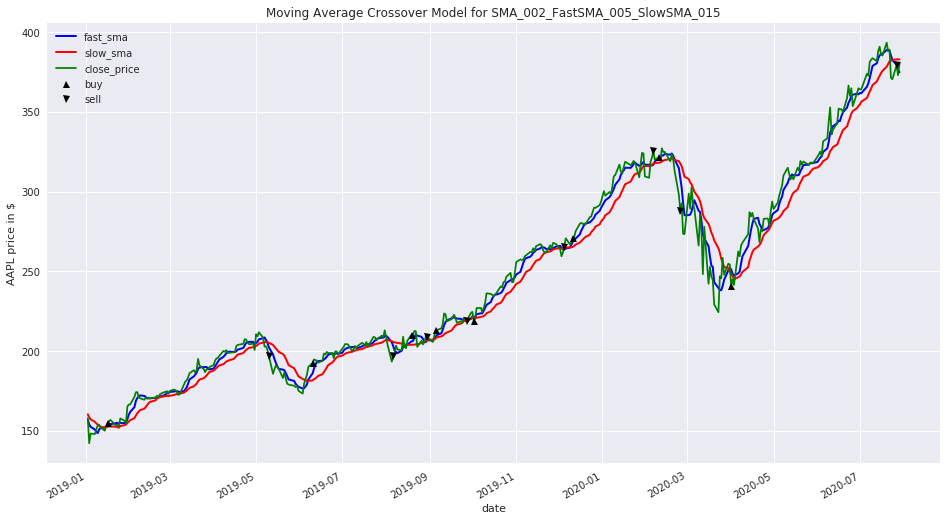

In [35]:
# Display the details for the top model
return_list = [ema_performance_summary.iloc[0]['return_value'], sma_performance_summary.iloc[0]['return_value'], 
               fast_ema_slow_sma_performance.iloc[0]['return_value'], fast_sma_slow_ema_performance.iloc[0]['return_value']]
performance_list = [ema_performance_summary, sma_performance_summary, fast_ema_slow_sma_performance, fast_sma_slow_ema_performance]
portfolio_list = [ema_portfolio_collection, sma_portfolio_collection, fast_ema_slow_sma_portfolios, fast_sma_slow_ema_portfolios]
model_list = [ema_model_collection, sma_model_collection, fast_ema_slow_sma_models, fast_sma_slow_ema_models]
fast_ma_list = ['fast_ema', 'fast_sma', 'fast_ema', 'fast_sma']
slow_ma_list = ['slow_ema', 'slow_sma', 'slow_sma', 'slow_ema']
top_model_return = max(return_list)
top_model_index = return_list.index(top_model_return)
top_model_name = performance_list[top_model_index].iloc[0]['model_name']
display_signals_transactions(top_model_name, portfolio_list[top_model_index], model_list[top_model_index])
print()
draw_model_graphs(top_model_name, model_list[top_model_index][top_model_name], fast_ma_list[top_model_index], slow_ma_list[top_model_index])

## Task 5. Evaluate Performance

In [36]:
print('The best model found is:', top_model_name)
print('The best profit/loss for the investing period is: $%.2f' % top_model_return)
if initial_capital != 0:
    print('The best return percentage for initial capital is: %.2f%%' % (top_model_return / initial_capital * 100))

The best model found is: SMA_002_FastSMA_005_SlowSMA_015
The best profit/loss for the investing period is: $266.52


In [37]:
# Calculate the stock's performance for a long-only model
model_template = model_template[model_start_date:model_end_date]
print('The performance of the long-only model from day one is: $%.2f' %(model_template.iloc[-1]['close_price'] - model_template.iloc[0]['open_price']))

The performance of the long-only model from day one is: $225.27


In [38]:
print ('Total time for the script:',(datetime.now() - startTimeScript))

Total time for the script: 0:08:34.174378
